<br></br>
# **나이브베이즈 한글 적용**
네이버 영화리뷰 데이터 활용
1. 0 : 부정적인 리뷰
1. 1 : 긍정적인 리뷰

<br></br>
## **1 NAVER 영화리뷰 데이터 전처리**
1. https://github.com/e9t/nsmc
1. https://www.nltk.org/book/ch06.html

In [1]:
! cat ./data/ratings_test.txt | head -n 10

cat: ./data/ratings_test.txt: 그런 파일이나 디렉터리가 없습니다


In [2]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
        
    from random import randint
    random_data = [data[randint(1, len(data))]  for no in range(int(len(data)/50)) ]
    return random_data

train_data = read_data('../data/ratings_train.txt')
test_data  = read_data('../data/ratings_test.txt')
print('Train_data : {}\nsample     : {}'.format(len(train_data), train_data[:3]))
print('Test_data  : {}\nsample     : {}'.format(len(test_data),  test_data[:3]))

Train_data : 3000
sample     : [['5168111', '특별할것없는 저예산의 이런 칙칙한영회 이젠 정말싫다..', '0'], ['9505496', '신유주배우 흥하세요~~', '1'], ['4541382', '마지막 장면의 여운이 잊혀지지 않는다', '1']]
Test_data  : 1000
sample     : [['1643344', '관객을 유혹하기엔 매력이 충분하지 못하다.', '0'], ['10269495', '다시봐도 정말 감동적인 영화. 오직 그대만.', '1'], ['9489939', '금보 라는 배우 연기 잘하네.... 대성해라~~~^^', '1']]


In [3]:
%%time
from konlpy.tag import Okt
pos_tagger = Okt()

def tokenize(doc):
    result = ['/'.join(t) for t in pos_tagger.pos(doc, norm=True, stem=True)]
    return result 

train_docs = [(tokenize(row[1]), row[2])    for row in train_data]
test_docs  = [(tokenize(row[1]), row[2])    for row in test_data]

from pprint import pprint
pprint(train_docs[:2])

[(['특별하다/Adjective',
   '없다/Adjective',
   '저/Determiner',
   '예산/Noun',
   '의/Josa',
   '이렇다/Adjective',
   '칙칙하다/Adjective',
   '영/Modifier',
   '회/Noun',
   '이/Determiner',
   '젠/Noun',
   '정말/Noun',
   '싫다/Adjective',
   '../Punctuation'],
  '0'),
 (['신/Modifier', '유주/Noun', '배우/Noun', '흥/Noun', '하다/Verb', '~~/Punctuation'],
  '1')]
CPU times: user 26.4 s, sys: 394 ms, total: 26.8 s
Wall time: 14.6 s


In [4]:
tokens = [t   for d in train_docs 
              for t in d[0]]
print("Token Total :{}\nSample : {}".format(
    len(tokens), tokens[:5]))

Token Total :43413
Sample : ['특별하다/Adjective', '없다/Adjective', '저/Determiner', '예산/Noun', '의/Josa']


<br></br>
## **2 nltk 를 활용하여 연산모델 만들기**
https://github.com/e9t/nsmc

In [5]:
import nltk
text = nltk.Text(tokens, name='NMSC')

print("number of Token : {} \nunique Token    : {}\n".format(
    len(text.tokens), len(set(text.tokens))))
pprint(text.vocab().most_common(5))    

number of Token : 43413 
unique Token    : 6734

[('./Punctuation', 1344),
 ('영화/Noun', 993),
 ('하다/Verb', 884),
 ('보다/Verb', 791),
 ('이/Josa', 786)]


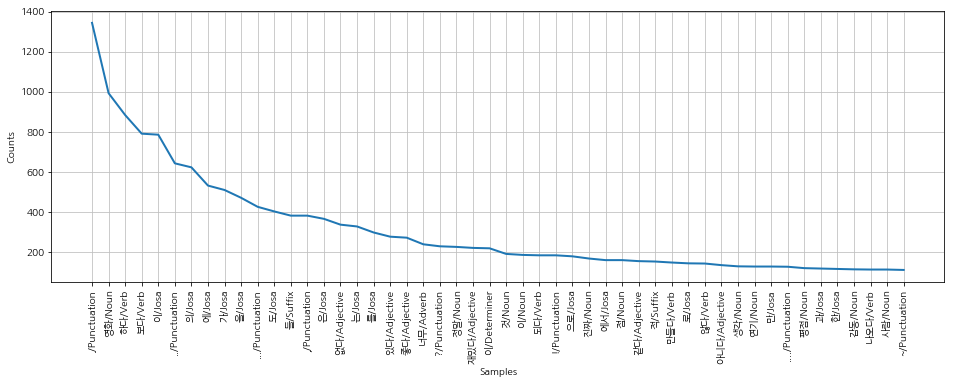

In [6]:
%matplotlib inline
from matplotlib import rc
rc('font', family='NanumGothic')

import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))
text.plot(50) 

<br></br>
## **3 모델의 정확도/ 일반화를 높이는 추가작업**
우도 상위 4000개 데이터를 추출

In [7]:
selected_words = [f[0] for f in text.vocab().most_common(4000)]
selected_words[:5]

['./Punctuation', '영화/Noun', '하다/Verb', '보다/Verb', '이/Josa']

In [8]:
%%time
def term_exists(doc):
    return {'exists({})'.format(word): (word in set(doc)) for word in selected_words}

train_docs = train_docs[:10000]
train_xy   = [(term_exists(d), c) for d, c in train_docs]
test_xy    = [(term_exists(d), c) for d, c in test_docs]

CPU times: user 14.1 s, sys: 556 ms, total: 14.7 s
Wall time: 14.7 s


In [9]:
%%time
classifiers = nltk.NaiveBayesClassifier.train(train_xy)

CPU times: user 14.4 s, sys: 554 µs, total: 14.4 s
Wall time: 14.4 s


<br></br>
## **4 생성한 모델을 평가**
Accuracy
1. 0 : 부정리뷰
1. 1 : 긍정리뷰

In [10]:
classifiers.labels()

['0', '1']

In [11]:
classifiers.show_most_informative_features(15)

Most Informative Features
          exists(꼭/Noun) = True                1 : 0      =     20.3 : 1.0
         exists(최악/Noun) = True                0 : 1      =     18.8 : 1.0
         exists(최고/Noun) = True                1 : 0      =     14.7 : 1.0
          exists(짱/Noun) = True                1 : 0      =     13.9 : 1.0
        exists(쓰레기/Noun) = True                0 : 1      =     12.1 : 1.0
   exists(아깝다/Adjective) = True                0 : 1      =     12.0 : 1.0
   exists(귀엽다/Adjective) = True                1 : 0      =     11.3 : 1.0
          exists(류/Noun) = True                0 : 1      =     10.7 : 1.0
         exists(무슨/Noun) = True                0 : 1      =     10.7 : 1.0
         exists(대박/Noun) = True                1 : 0      =     10.7 : 1.0
  exists(재미없다/Adjective) = True                0 : 1      =     10.6 : 1.0
    exists(싫다/Adjective) = True                0 : 1      =     10.0 : 1.0
         exists(추천/Noun) = True                1 : 0      =      9.4 : 1.0

In [12]:
%%time
'네이버 긍부정 모델의 Accuracy : {}'.format(
    nltk.classify.accuracy(classifiers, test_xy))

CPU times: user 10.2 s, sys: 4.18 ms, total: 10.2 s
Wall time: 10.2 s


'네이버 긍부정 모델의 Accuracy : 0.772'

<br></br>
## **5 모델의 활용**
1. 0 : 부정리뷰
1. 1 : 긍정리뷰

In [13]:
review = """영화가 졸잼 굿"""

In [14]:
review = tokenize(review)    # 문법 Tag 추가한 객체로 변환
review

['영화/Noun', '가/Josa', '졸잼/Noun', '굿/Noun']

In [15]:
review = term_exists(review) # 기준 용어들이 포함여부 판단
for k, v in review.items():
    if v == True:
        print("{} = {}".format(k, v))

exists(영화/Noun) = True
exists(가/Josa) = True
exists(굿/Noun) = True


In [16]:
classifiers.classify(review)  # 분류모델 평가

'1'